<a href="https://colab.research.google.com/github/Christian-F-Badillo/spaceship_kaggle_competition/blob/main/Spaceship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spaceship Competititon

Notebook for the spaceship competition.

- The goal it's apply in a simple dataset different machine learning algorithms.

> Author: [Christian Badillo](https://github.com/Christian-F-Badillo/).

## Simple EDA

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

### Helper Functions

In [80]:
# @title Preprocessing Functions
def dummie_target(df: pd.DataFrame, target_name: str):
    values = df[target_name].unique()
    dummies = np.arange(0, len(values))
    dummie_list = []

    for i in df[target_name]:
        for dum in dummies:
            if i == values[dum]:
                dummie_list.append(dum)

    return dummie_list

def family_members(df: pd.DataFrame, column: str):
    names = df[column].unique()
    members = np.repeat(-1.0, len(names))

    family_dic = {i[0]:i[1] for i in zip(names, members)}
    family = []

    for last in df[column]:
        for number in range(len(names)):
            if last == names[number]:
                family_dic[last] += 1
            else:
                continue

    for i in df[column]:
        for j in family_dic.keys():
            if i == j:
                family.append(family_dic[j])

    return pd.Series(family, name = 'Family Members')

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

def shuffle_and_split_data(X, y, ratio, seed):
  """
  Helper function to shuffle and split incoming data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]

  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(N * ratio)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

### Data Load

In [3]:
url_train = "https://raw.githubusercontent.com/Christian-F-Badillo/spaceship_kaggle_competition/main/spaceship-titanic/train.csv"
url_test = "https://raw.githubusercontent.com/Christian-F-Badillo/spaceship_kaggle_competition/main/spaceship-titanic/test.csv"

train_data = pd.read_csv(url_train)
test_data = pd.read_csv(url_test)

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train_data.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
train_drop_na = train_data.dropna()
train_drop_na.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True
11,0008_03,Europa,False,B/1/P,55 Cancri e,45.0,False,39.0,7295.0,589.0,110.0,124.0,Wezena Flatic,True


In [8]:
train_drop_na.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [9]:
train_drop_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6606 non-null   object 
 1   HomePlanet    6606 non-null   object 
 2   CryoSleep     6606 non-null   object 
 3   Cabin         6606 non-null   object 
 4   Destination   6606 non-null   object 
 5   Age           6606 non-null   float64
 6   VIP           6606 non-null   object 
 7   RoomService   6606 non-null   float64
 8   FoodCourt     6606 non-null   float64
 9   ShoppingMall  6606 non-null   float64
 10  Spa           6606 non-null   float64
 11  VRDeck        6606 non-null   float64
 12  Name          6606 non-null   object 
 13  Transported   6606 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 729.0+ KB


In [10]:
ids = train_drop_na.PassengerId
train_drop_na.drop("PassengerId", inplace=True, axis = 1)

<ipython-input-10-2e65c0409b7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_drop_na.drop("PassengerId", inplace=True, axis = 1)


In [11]:
train_data_dummies = train_drop_na.copy()
columns = ["HomePlanet", "VIP", 'Cabin', "CryoSleep", "Destination", 'Transported']

for i in columns:
    train_data_dummies[i] = dummie_target(train_data_dummies, i)

In [12]:
train_data_dummies.head(10)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,1,0,1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0,0,2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0,0,2,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,1,0,3,0,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1
5,1,0,4,1,44.0,0,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,1
6,1,0,5,0,26.0,0,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,1
8,1,0,6,0,35.0,0,0.0,785.0,17.0,216.0,0.0,Andona Beston,1
9,0,1,7,2,14.0,0,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,1
11,0,0,7,2,45.0,0,39.0,7295.0,589.0,110.0,124.0,Wezena Flatic,1


In [13]:
name_lastname = train_data_dummies.Name.str.split(expand = True)
name_lastname.rename({0: 'Name', 1: 'Last Name'}, inplace = True, axis = 1)
name_lastname.head()

,Name,Last Name
0,Maham,Ofracculy
1,Juanna,Vines
2,Altark,Susent
3,Solam,Susent
4,Willy,Santantines


In [14]:
name_lastname.shape

(6606, 2)

In [15]:
members = family_members(name_lastname, "Last Name")

In [16]:
members.shape

(6606,)

In [145]:
train_data_dummies['Family Members'] = members
train_last = train_data_dummies.copy()
train_last.drop('Name', axis = 1, inplace=True)
train_last.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Family Members
0,0,0,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,1,0,1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2.0
2,0,0,2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,4.0
3,0,0,2,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,4.0
4,1,0,3,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,4.0


### Simple Visualization

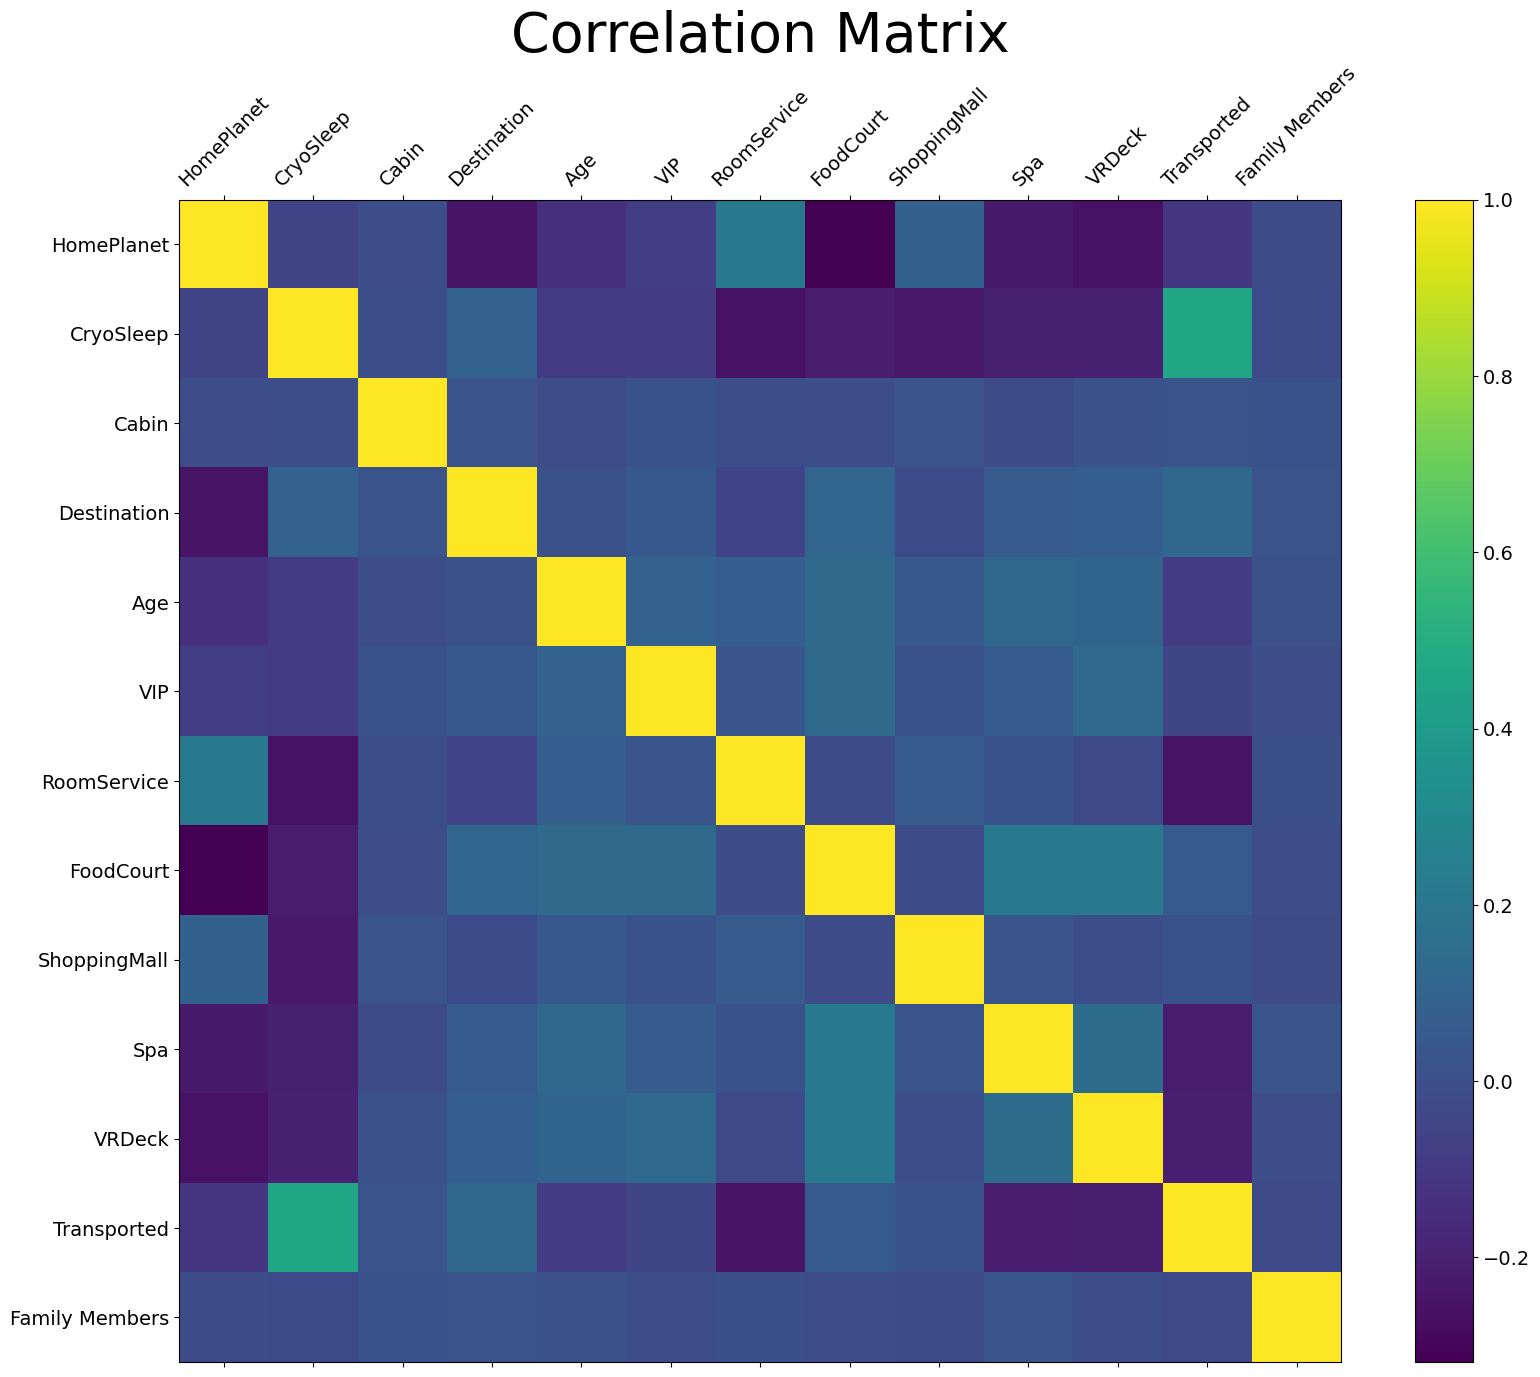

In [51]:
df = train_last

f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=40)
plt.show()

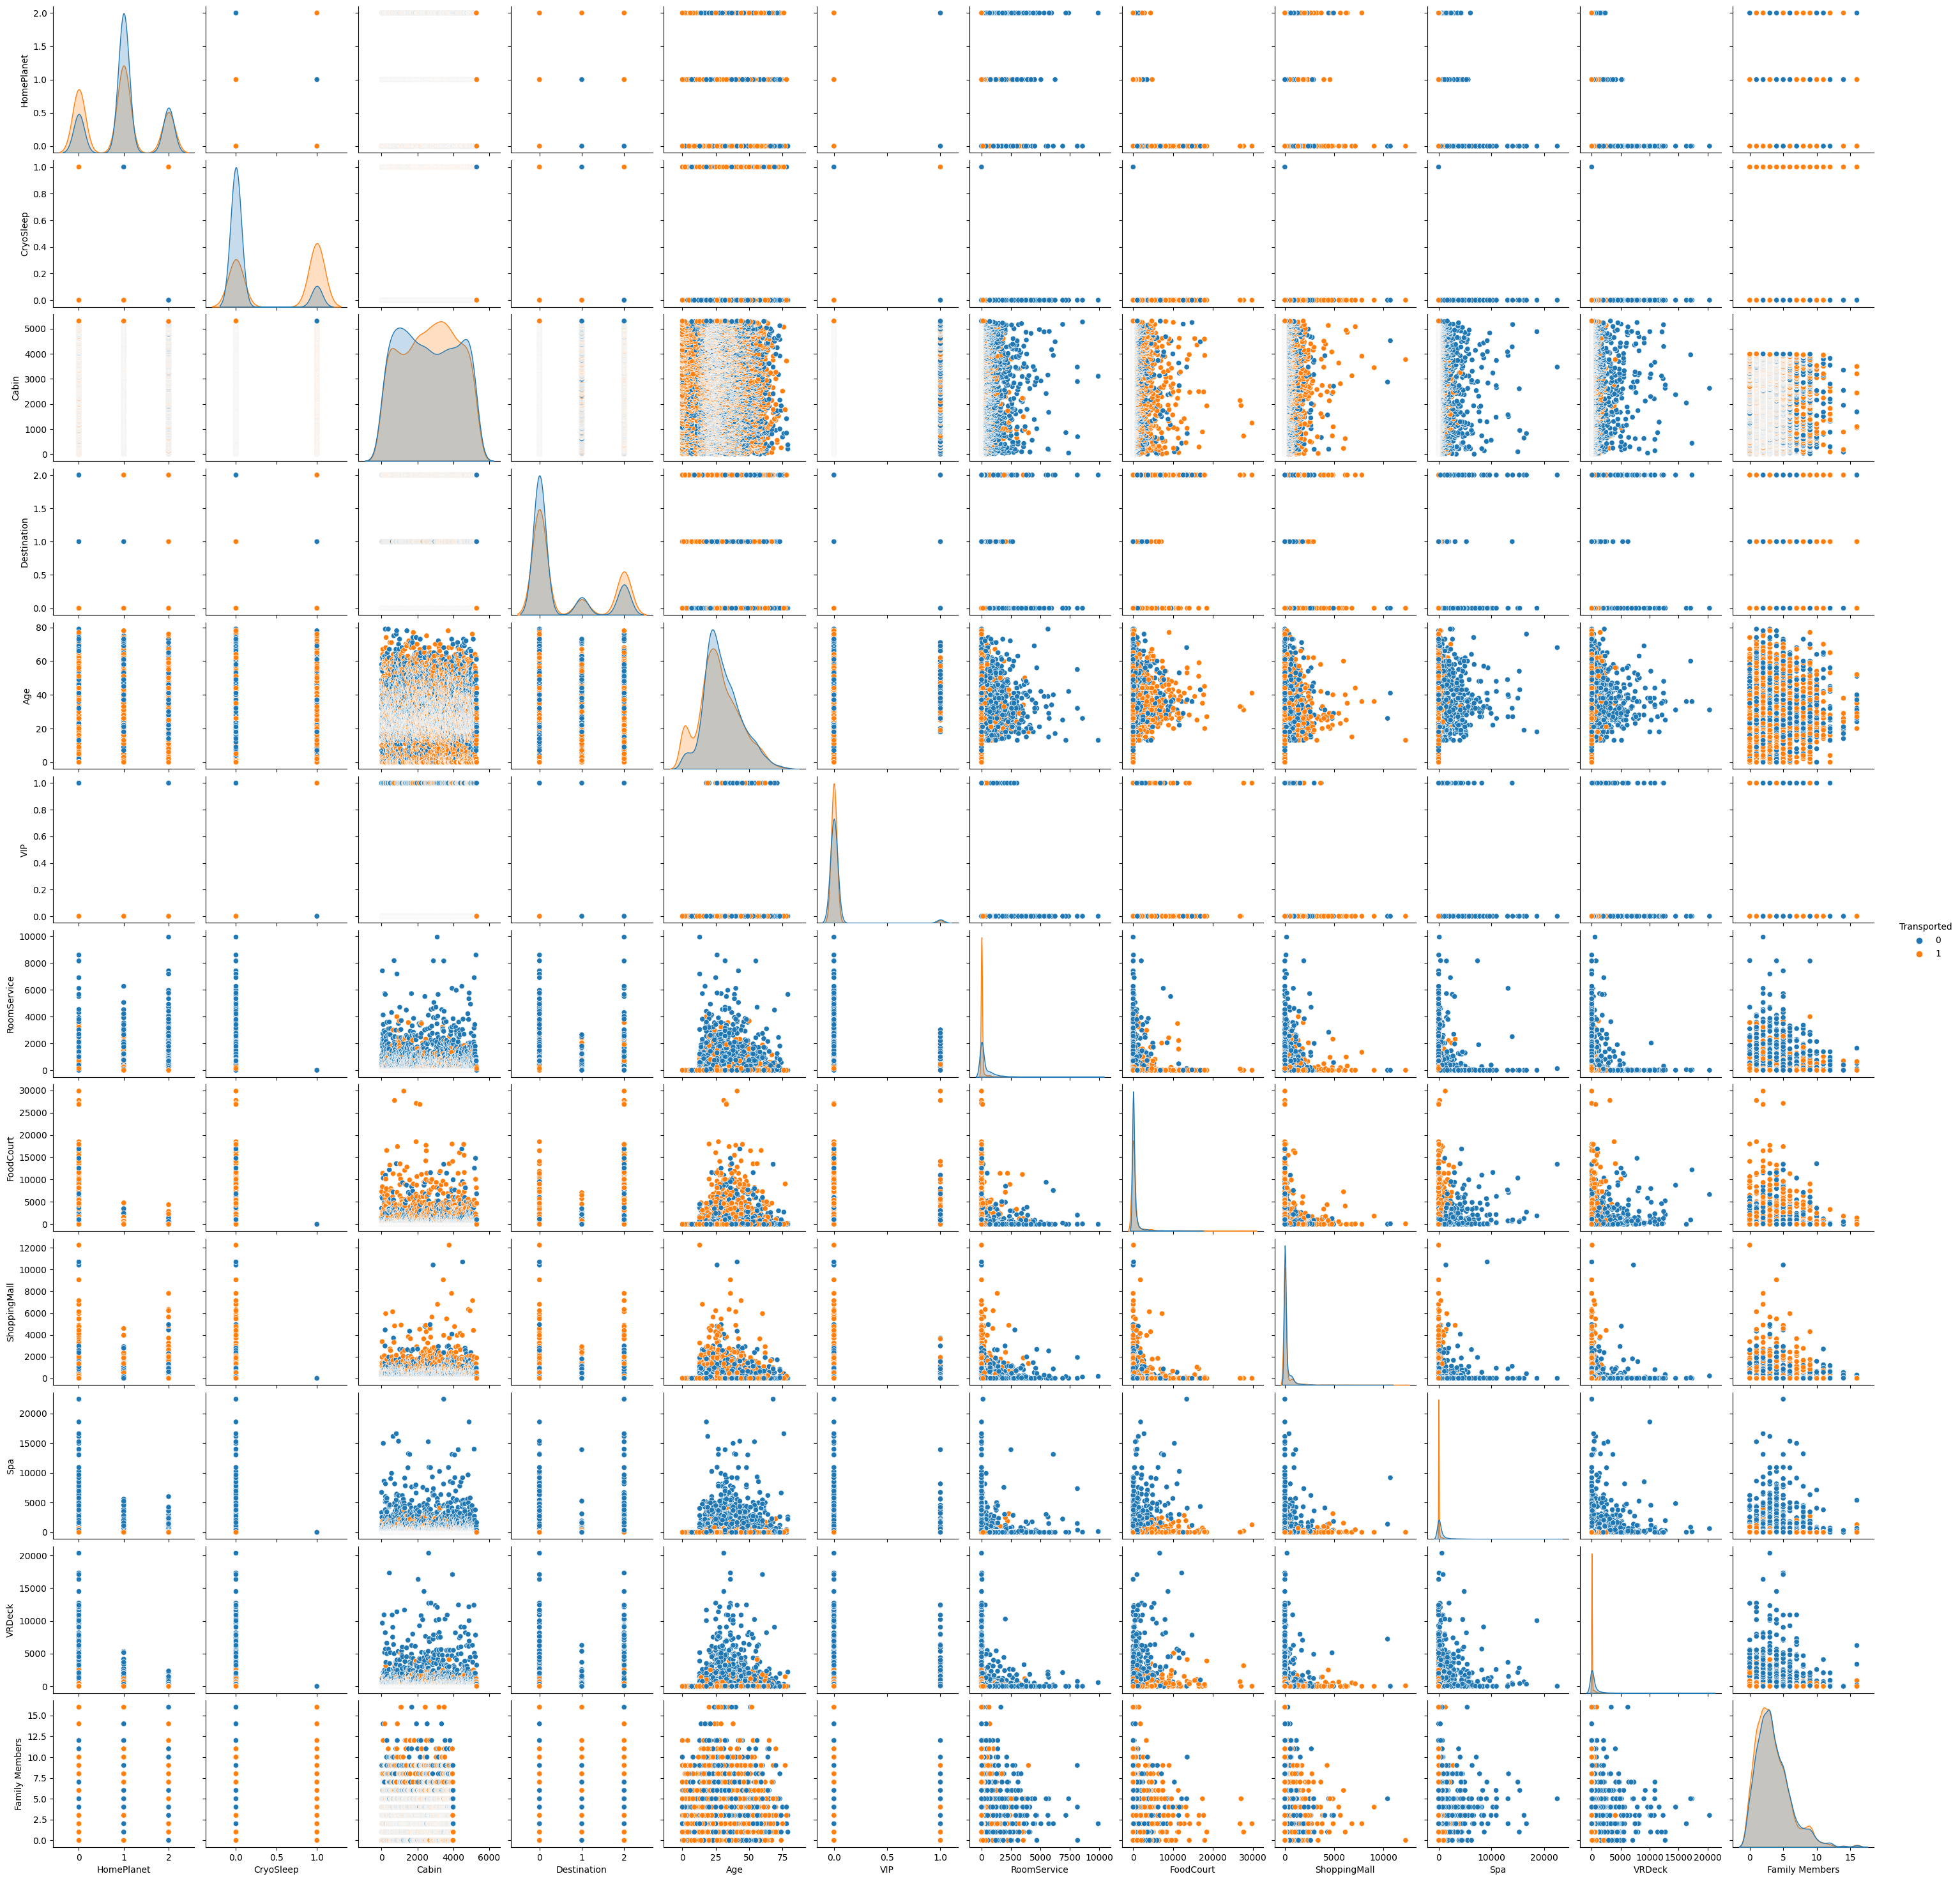

In [52]:
sns.pairplot(df, hue = 'Transported')
plt.show()

## Modelling

In [146]:
X_data = train_last.drop('Transported', axis = 1)
Y_data = train_last['Transported']

In [148]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

norm = StandardScaler()
train_norm = norm.fit_transform(X_data.values)

minmax = MinMaxScaler()
train_minmax = minmax.fit_transform(X_data.values)